In [1]:
import joblib
from wmb import cemba, brain
from ALLCools.mcds import MCDS
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
from ALLCools.clustering import tsne, significant_pc_test
from ALLCools.plot import *
from sklearn.preprocessing import normalize
from itertools import cycle, islice

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'



In [2]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata


In [4]:
pd.set_option('display.max_columns', None)


In [9]:
meta_rs1 = cemba.get_mc_mapping_metric(pass_basic_qc_only=True, remove_outlier_ids=False)
meta_rs1


mCCCFrac   mCGFrac   mCHFrac  FinalmCReads DissectionRegion  \
cell                                                                      
10A_M_1     0.008874  0.819390  0.036336     1073981.0            RSP-4   
10A_M_100   0.007105  0.762382  0.019705     1108484.0            RSP-4   
10A_M_1000  0.006450  0.744689  0.016373     1443814.0            RSP-4   
10A_M_1001  0.007433  0.780743  0.029361     1372174.0            RSP-4   
10A_M_1002  0.006215  0.741165  0.018129     1650777.0            RSP-4   
...              ...       ...       ...           ...              ...   
17A_M_3051  0.007412  0.747842  0.018610     1559491.0             CB-4   
17A_M_3052  0.008806  0.830814  0.043916     1219087.0             CB-4   
17A_M_3053  0.006352  0.768759  0.023178     1723321.0             CB-4   
17A_M_3054  0.006006  0.755818  0.018815     1673963.0             CB-4   
17A_M_3055  0.006692  0.780684  0.027004     1485227.0             CB-4   

                        Plate  Col384  Row384  Slice      Sample Technology  \
cell                                                                          
10A_M_1     CEMBA190423_10A_1       0       1     10  10A_190423  snmC-seq2   
10A_M_100   CEMBA190423_10A_2       0       3     10  10A_190423  snmC-seq2   
10A_M_1000  CEMBA190423_10A_4       7       5     10  10A_190423  snmC-seq2   
10A_M_1001  CEMBA190423_10A_3       8       4     10  10A_190423  snmC-seq2   
10A_M_1002  CEMBA190423_10A_3       8       5     10  10A_190423  snmC-seq2   
...                       ...     ...     ...    ...         ...        ...   
17A_M_3051  CEMBA210812_17A_4       1      14     17  17A_210812  snmC-seq3   
17A_M_3052  CEMBA210812_17A_4       0      15     17  17A_210812  snmC-seq3   
17A_M_3053  CEMBA210812_17A_4      12      15     17  17A_210812  snmC-seq3   
17A_M_3054  CEMBA210812_17A_4      13      15     17  17A_210812  snmC-seq3   
17A_M_3055  CEMBA210812_17A_4       1      15     17  17A_210812  snmC-seq3   

            InputReads  PassBasicQC  PlateNormCov CEMBARegion MajorRegion  \
cell                                                                        
10A_M_1        2252674         True      0.834409         10A   Isocortex   
10A_M_100      2549478         True      0.842048         10A   Isocortex   
10A_M_1000     3342484         True      1.031215         10A   Isocortex   
10A_M_1001     3220214         True      0.942444         10A   Isocortex   
10A_M_1002     3871980         True      1.133796         10A   Isocortex   
...                ...          ...           ...         ...         ...   
17A_M_3051     4589584         True      1.090938         17A          CB   
17A_M_3052     3510150         True      0.852810         17A          CB   
17A_M_3053     4903466         True      1.205545         17A          CB   
17A_M_3054     4773312         True      1.171017         17A          CB   
17A_M_3055     4205502         True      1.038987         17A          CB   

           SubRegion  
cell                  
10A_M_1          RSP  
10A_M_100        RSP  
10A_M_1000       RSP  
10A_M_1001       RSP  
10A_M_1002       RSP  
...              ...  
17A_M_3051       CBX  
17A_M_3052       CBX  
17A_M_3053       CBX  
17A_M_3054       CBX  
17A_M_3055       CBX  

[310605 rows x 17 columns]

In [10]:
rs1_mcds = MCDS.open(cemba.CEMBA_SNMC_MCDS_PATH, var_dim='chrom100k', use_obs=meta_rs1.index)
rs1_mcds


<xarray.MCDS>
Dimensions:             (cell: 310605, chrom100k: 27269, count_type: 2, mc_type: 2)
Coordinates:
  * cell                (cell) <U15 '10A_M_1181' '10A_M_1194' ... '9L2_M_1341'
  * chrom100k           (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
    chrom100k_chrom     (chrom100k) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY'
    chrom100k_cov_mean  (chrom100k) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    chrom100k_end       (chrom100k) int64 100000 200000 ... 91700000 91744698
    chrom100k_start     (chrom100k) int64 0 100000 200000 ... 91600000 91700000
  * count_type          (count_type) <U3 'mc' 'cov'
  * mc_type             (mc_type) <U3 'CHN' 'CGN'
Data variables:
    chrom100k_da        (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1000, 27269, 1, 1), meta=np.ndarray>
    chrom100k_da_frac   (cell, chrom100k, mc_type) float16 dask.array<chunksize=(1000, 27269, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

## concatenate MCDS

In [ ]:
rs2_mcds = MCDS.open('/gale/netapp/entex/CEMBA_RS2/*/matrix/*.mcds',
                     var_dim=['chrom100k', 'chrom5k', 'geneslop2k'])

In [3]:
rs2_mcds

<xarray.MCDS>
Dimensions:                    (mc_type: 2, cell: 75742, chrom100k: 27269, count_type: 2, chrom5k: 545118, geneslop2k: 32208)
Coordinates: (12/15)
  * mc_type                    (mc_type) <U3 'CGN' 'CHN'
  * cell                       (cell) <U99 '180118_CEMBA_mm_P56_P63_RS2_18011...
  * chrom100k                  (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
    chrom100k_chrom            (chrom100k) <U5 dask.array<chunksize=(13635,), meta=np.ndarray>
    chrom100k_end              (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_start            (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    ...                         ...
    chrom5k_end                (chrom5k) int64 dask.array<chunksize=(68140,), meta=np.ndarray>
    chrom5k_start              (chrom5k) int64 dask.array<chunksize=(68140,), meta=np.ndarray>
  * geneslop2k                 (geneslop2k) <U18 'ENSMUSG00000051951' ... 'EN...
    geneslop2k_chrom           (geneslop2k) <U5 dask.array<chunksize=(16104,), meta=np.ndarray>
    geneslop2k_end             (geneslop2k) int64 dask.array<chunksize=(32208,), meta=np.ndarray>
    geneslop2k_start           (geneslop2k) int64 dask.array<chunksize=(32208,), meta=np.ndarray>
Data variables:
    chrom100k_da               (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(13, 13635, 1, 1), meta=np.ndarray>
    chrom5k_da_CGN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(7, 68140), meta=np.ndarray>
    geneslop2k_da              (cell, geneslop2k, mc_type, count_type) uint32 dask.array<chunksize=(13, 16104, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [4]:
rs2_mcds.add_mc_frac(var_dim='chrom100k')
rs2_mcds.add_mc_frac(var_dim='geneslop2k')


In [5]:
rs2_mcds.write_dataset(
    output_path='/gale/netapp/entex/CEMBA_RS2/merged/matrix/CEMBA.epiretro.mcds',
    mode='w',
    obs_dim='cell',
    var_dims= ['chrom100k', 'chrom5k', 'geneslop2k'],
    use_obs=None,
    chunks={'cell': 1000, 'mc_type': 1, 'count_type': 1})


Saving chrom100k
Saving chunk 0: 0 - 1000


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 1: 1000 - 2000
Saving chunk 2: 2000 - 3000
Saving chunk 3: 3000 - 4000
Saving chunk 4: 4000 - 5000
Saving chunk 5: 5000 - 6000
Saving chunk 6: 6000 - 7000
Saving chunk 7: 7000 - 8000
Saving chunk 8: 8000 - 9000
Saving chunk 9: 9000 - 10000
Saving chunk 10: 10000 - 11000
Saving chunk 11: 11000 - 12000
Saving chunk 12: 12000 - 13000
Saving chunk 13: 13000 - 14000
Saving chunk 14: 14000 - 15000
Saving chunk 15: 15000 - 16000
Saving chunk 16: 16000 - 17000
Saving chunk 17: 17000 - 18000
Saving chunk 18: 18000 - 19000
Saving chunk 19: 19000 - 20000


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 20: 20000 - 21000
Saving chunk 21: 21000 - 22000
Saving chunk 22: 22000 - 23000
Saving chunk 23: 23000 - 24000
Saving chunk 24: 24000 - 25000
Saving chunk 25: 25000 - 26000
Saving chunk 26: 26000 - 27000
Saving chunk 27: 27000 - 28000
Saving chunk 28: 28000 - 29000
Saving chunk 29: 29000 - 30000
Saving chunk 30: 30000 - 31000
Saving chunk 31: 31000 - 32000
Saving chunk 32: 32000 - 33000
Saving chunk 33: 33000 - 34000


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Saving chunk 34: 34000 - 35000
Saving chunk 35: 35000 - 36000
Saving chunk 36: 36000 - 37000
Saving chunk 37: 37000 - 38000
Saving chunk 38: 38000 - 39000
Saving chunk 39: 39000 - 40000
Saving chunk 40: 40000 - 41000
Saving chunk 41: 41000 - 42000
Saving chunk 42: 42000 - 43000
Saving chunk 43: 43000 - 44000
Saving chunk 44: 44000 - 45000
Saving chunk 45: 45000 - 46000
Saving chunk 46: 46000 - 47000
Saving chunk 47: 47000 - 48000
Saving chunk 48: 48000 - 49000
Saving chunk 49: 49000 - 50000
Saving chunk 50: 50000 - 51000
Saving chunk 51: 51000 - 52000
Saving chunk 52: 52000 - 53000
Saving chunk 53: 53000 - 54000
Saving chunk 54: 54000 - 55000
Saving chunk 55: 55000 - 56000
Saving chunk 56: 56000 - 57000
Saving chunk 57: 57000 - 58000
Saving chunk 58: 58000 - 59000
Saving chunk 59: 59000 - 60000
Saving chunk 60: 60000 - 61000
Saving chunk 61: 61000 - 62000
Saving chunk 62: 62000 - 63000
Saving chunk 63: 63000 - 64000
Saving chunk 64: 64000 - 65000
Saving chunk 65: 65000 - 66000
Saving c

In [5]:
meta_path_list = glob('/gale/netapp/entex/CEMBA_RS2/*Q*/matrix/cell*meta.csv.gz')

meta = []
for x in meta_path_list:
    tmp = pd.read_csv(x, header=0, index_col=0)
    tmp['Quarter'] = x.split('/')[5]
    meta.append(tmp)
    
meta = pd.concat(meta).sort_index()
meta



mCCCmC  mCCCCov    mCHmC  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...    9844  1514410   713548   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   12966  1932614   993131   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   15362  2154393  1158448   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   12869  2133427   912284   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...    4961   990905   330512   
...                                                    ...      ...      ...   
Pool180_Plate9-6-M14-O24                              9580  2012934   559169   
Pool180_Plate9-6-M14-P11                              9971  1824939   667860   
Pool180_Plate9-6-M14-P12                              8302  1339811   591139   
Pool180_Plate9-6-M14-P23                              7263  1333559   522667   
Pool180_Plate9-6-M14-P24                              7094  1332367   442793   

                                                      mCHCov    mCGmC  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  22279283   763270   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  29131404   948796   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  32268936  1063678   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  31908383  1034767   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  15008592   486792   
...                                                      ...      ...   
Pool180_Plate9-6-M14-O24                            30011980  1012069   
Pool180_Plate9-6-M14-P11                            26884733   914838   
Pool180_Plate9-6-M14-P12                            19994728   700074   
Pool180_Plate9-6-M14-P23                            19894570   695740   
Pool180_Plate9-6-M14-P24                            19594842   680151   

                                                     mCGCov  mCCCFrac  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   983786  0.006500   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1224023  0.006709   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1370904  0.007131   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1338041  0.006032   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   629360  0.005007   
...                                                     ...       ...   
Pool180_Plate9-6-M14-O24                            1372123  0.004759   
Pool180_Plate9-6-M14-P11                            1205206  0.005464   
Pool180_Plate9-6-M14-P12                             883342  0.006196   
Pool180_Plate9-6-M14-P23                             889187  0.005446   
Pool180_Plate9-6-M14-P24                             869854  0.005324   

                                                     mCHFrac   mCGFrac  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.032027  0.775850   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.034091  0.775146   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.035900  0.775895   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.028591  0.773345   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.022022  0.773471   
...                                                      ...       ...   
Pool180_Plate9-6-M14-O24                            0.018632  0.737593   
Pool180_Plate9-6-M14-P11                            0.024842  0.759072   
Pool180_Plate9-6-M14-P12                            0.029565  0.792529   
Pool180_Plate9-6-M14-P23                            0.026272  0.782445   
Pool180_Plate9-6-M14-P24                            0.022597  0.781914   

                                                    FinalmCReads  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1090870   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1458065   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1614993   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1598778   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...        762007   
...                                     

In [7]:
meta['FinalmCReads'].describe()

count    6.381600e+04
mean     1.312792e+06
std      8.431663e+05
min      1.000380e+05
25%      7.827785e+05
50%      1.163415e+06
75%      1.617513e+06
max      2.250087e+07
Name: FinalmCReads, dtype: float64

## Remove low quality experiments and cells

In [44]:
order = meta.groupby(by=['Exp'])['mCCCFrac'].median().sort_values()
count = meta['Exp'].value_counts()
order[-20:]


Exp
Tm4H5H6F7F     0.011799
Um7G8G         0.012113
Wm11G12F13C    0.015379
Tm7E8F         0.016082
Wm3D           0.016527
Tf4H5H6F7F     0.017747
Wf10A          0.020387
Wf9B           0.021170
Tm7G8G         0.022112
Wf9A           0.022147
Uf7G8G         0.027996
Tf9K10G        0.028468
Tf7G8G         0.030259
Wf2D3E4F5G     0.031314
Wm4A           0.032137
Wm9D           0.045176
Wm10C          0.047891
Wf10C          0.048701
Wm6D7D8D9E     0.060917
Wf6D7D8D9E     0.077115
Name: mCCCFrac, dtype: float64

In [42]:
meta['Exp'].unique().shape

(715,)

In [45]:
filterexp = order[order<0.025].index
meta = meta[(meta['mCCCFrac']<0.05) & (meta['FinalmCReads']>500000) & (meta['FinalmCReads']<10000000) & (meta['Exp'].isin(filterexp))]
meta


mCCCmC  mCCCCov    mCHmC  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...    9844  1514410   713548   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   12966  1932614   993131   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   15362  2154393  1158448   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   12869  2133427   912284   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...    4961   990905   330512   
...                                                    ...      ...      ...   
Pool180_Plate9-6-M14-O24                              9580  2012934   559169   
Pool180_Plate9-6-M14-P11                              9971  1824939   667860   
Pool180_Plate9-6-M14-P12                              8302  1339811   591139   
Pool180_Plate9-6-M14-P23                              7263  1333559   522667   
Pool180_Plate9-6-M14-P24                              7094  1332367   442793   

                                                      mCHCov    mCGmC  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  22279283   763270   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  29131404   948796   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  32268936  1063678   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  31908383  1034767   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  15008592   486792   
...                                                      ...      ...   
Pool180_Plate9-6-M14-O24                            30011980  1012069   
Pool180_Plate9-6-M14-P11                            26884733   914838   
Pool180_Plate9-6-M14-P12                            19994728   700074   
Pool180_Plate9-6-M14-P23                            19894570   695740   
Pool180_Plate9-6-M14-P24                            19594842   680151   

                                                     mCGCov  mCCCFrac  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   983786  0.006500   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1224023  0.006709   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1370904  0.007131   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  1338041  0.006032   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...   629360  0.005007   
...                                                     ...       ...   
Pool180_Plate9-6-M14-O24                            1372123  0.004759   
Pool180_Plate9-6-M14-P11                            1205206  0.005464   
Pool180_Plate9-6-M14-P12                             883342  0.006196   
Pool180_Plate9-6-M14-P23                             889187  0.005446   
Pool180_Plate9-6-M14-P24                             869854  0.005324   

                                                     mCHFrac   mCGFrac  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.032027  0.775850   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.034091  0.775146   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.035900  0.775895   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.028591  0.773345   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...  0.022022  0.773471   
...                                                      ...       ...   
Pool180_Plate9-6-M14-O24                            0.018632  0.737593   
Pool180_Plate9-6-M14-P11                            0.024842  0.759072   
Pool180_Plate9-6-M14-P12                            0.029565  0.792529   
Pool180_Plate9-6-M14-P23                            0.026272  0.782445   
Pool180_Plate9-6-M14-P24                            0.022597  0.781914   

                                                    FinalmCReads  \
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1090870   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1458065   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1614993   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...       1598778   
180118_CEMBA_mm_P56_P63_RS2_180117_P1_180117_P2...        762007   
...                                     

In [46]:
meta['Exp'].unique().shape

(703,)

## L1 clustering for removing outlier

In [6]:
rs2_mcds = MCDS.open('/gale/netapp/entex/CEMBA_RS2/merged/matrix/CEMBA.epiretro.mcds', var_dim='chrom100k', use_obs=meta.index)
rs2_mcds


<xarray.MCDS>
Dimensions:            (cell: 56843, chrom100k: 27269, count_type: 2, mc_type: 2)
Coordinates:
  * cell               (cell) <U99 '180118_CEMBA_mm_P56_P63_RS2_180117_P1_180...
  * chrom100k          (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
    chrom100k_chrom    (chrom100k) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY'
    chrom100k_end      (chrom100k) int64 100000 200000 ... 91700000 91744698
    chrom100k_start    (chrom100k) int64 0 100000 200000 ... 91600000 91700000
  * count_type         (count_type) <U3 'mc' 'cov'
  * mc_type            (mc_type) <U3 'CGN' 'CHN'
Data variables:
    chrom100k_da       (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(1000, 27269, 1, 1), meta=np.ndarray>
    chrom100k_da_frac  (cell, chrom100k, mc_type) float64 dask.array<chunksize=(1000, 27269, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

In [11]:
model = joblib.load('/gale/netapp/entex/CEMBA_RS2/RS1/ReproduciblePCA/L1/mCH.ReproduciblePCA.lib')
binch_rs2 = model.mcds_to_adata_with_pc(rs2_mcds)
binch_rs1 = model.mcds_to_adata_with_pc(rs1_mcds)


Using user provided scaler.


In [12]:
model = joblib.load('/gale/netapp/entex/CEMBA_RS2/RS1/ReproduciblePCA/L1/mCG.ReproduciblePCA.lib')
bincg_rs2 = model.mcds_to_adata_with_pc(rs2_mcds)
bincg_rs1 = model.mcds_to_adata_with_pc(rs1_mcds)


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/scikit_learn-1.0-py3.7-linux-x86_64.egg/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Using user provided scaler.
Using user provided scaler.


In [17]:
meta['Study'] = 'CEMBA_EpiRetro'
meta_rs1['Study'] = 'CEMBA_snmC'


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipykernel-6.4.1-py3.7.egg/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
adata = anndata.AnnData(X=np.ones((meta_rs1.shape[0] + meta.shape[0],1)), 
                        obs=pd.concat([meta_rs1.loc[binch_rs1.obs.index], meta.loc[binch_rs2.obs.index]], axis=0))
adata.obsm['100kCH_pca'] = np.concatenate([binch_rs1.obsm['X_pca'], binch_rs2.obsm['X_pca']], axis=0)
adata.obsm['100kCG_pca'] = np.concatenate([bincg_rs1.obsm['X_pca'], bincg_rs2.obsm['X_pca']], axis=0)
adata


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipykernel-6.4.1-py3.7.egg/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


AnnData object with n_obs × n_vars = 367448 × 1
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'Study', 'mCCCmC', 'mCCCCov', 'mCHmC', 'mCHCov', 'mCGmC', 'mCGCov', 'Exp', 'Source', 'Target', 'Gender', 'Quarter'
    obsm: '100kCH_pca', '100kCG_pca'

In [23]:
significant_pc_test(adata, p_cutoff=0.05, obsm='100kCH_pca', update=False)
significant_pc_test(adata, p_cutoff=0.05, obsm='100kCG_pca', update=False)


Downsample PC matrix to 50000 cells to calculate significant PC components
144 components passed P cutoff of 0.05.
Downsample PC matrix to 50000 cells to calculate significant PC components
154 components passed P cutoff of 0.05.


154

In [27]:
from sklearn.preprocessing import normalize

adata.obsm['X_pca'] = np.concatenate([
    normalize(adata.obsm['100kCH_pca'][:, :150], axis=1),
    normalize(adata.obsm['100kCG_pca'][:, :150], axis=1),
], axis=1)


In [30]:
tsne(adata, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=50, n_jobs=-1)
dump_embedding(adata, 'tsne')
adata.obsm['100kCH100kCG_pc150pc150_tsne'] = adata.obsm['X_tsne'].copy()


In [80]:
len(adata_L1.obs.loc[adata_L1.obs['Study']=='CEMBA_snmC', 'Plate'].unique()) * 384

361728

In [31]:
plate = []
for x in meta.index:
    xx = x.replace('-','_').replace('_RS2','').replace('CEMBA','').split('_')
    if xx[-1][:3].upper()=='AD0':
        if int(xx[-1][3:])<7:
            plate.append('_'.join(xx[-6:-4]))
        else:
            plate.append('_'.join(xx[-4:-2]))
    else:
        plate.append('_'.join(xx[-5:-3]))

adata.obs.loc[meta.index, 'Plate'] = plate.copy()
plate_reads = adata.obs.groupby(by='Plate')['FinalmCReads'].median()
adata.obs['PlateNormReads'] = np.log2(adata.obs['FinalmCReads'] / plate_reads[adata.obs['Plate']].values)


In [50]:
rs1_annot = cemba.get_mc_annot()
rs1_annot


<xarray.CEMBAmCCellAnnotation>
Dimensions:                (cell: 301626, L1_cat: 61, L4Region_cat: 4673, l1_tsne: 2, l1_umap: 2, l2_tsne: 2, l2_umap: 2, l3_tsne: 2, l3_umap: 2, l4_tsne: 2, l4_umap: 2, mr_tsne: 2, mr_umap: 2)
Coordinates: (12/13)
  * cell                   (cell) object '10A_M_1181' ... '17A_M_2837'
  * L1_cat                 (L1_cat) object 'c0' 'c1' 'c10' ... 'c7' 'c8' 'c9'
  * L4Region_cat           (L4Region_cat) object 'c1_c0_c0_c0_r0' ... 'c5_c3_...
  * l1_tsne                (l1_tsne) <U9 'l1_tsne_0' 'l1_tsne_1'
  * l1_umap                (l1_umap) <U9 'l1_umap_0' 'l1_umap_1'
  * l2_tsne                (l2_tsne) <U9 'l2_tsne_0' 'l2_tsne_1'
    ...                     ...
  * l3_tsne                (l3_tsne) <U9 'l3_tsne_0' 'l3_tsne_1'
  * l3_umap                (l3_umap) <U9 'l3_umap_0' 'l3_umap_1'
  * l4_tsne                (l4_tsne) <U9 'l4_tsne_0' 'l4_tsne_1'
  * l4_umap                (l4_umap) <U9 'l4_umap_0' 'l4_umap_1'
  * mr_tsne                (mr_tsne) <U9 'mr_tsne_0' 'mr_tsne_1'
  * mr_umap                (mr_umap) <U9 'mr_umap_0' 'mr_umap_1'
Data variables: (12/25)
    CellType               (cell) object dask.array<chunksize=(37704,), meta=np.ndarray>
    L1                     (cell) object dask.array<chunksize=(37704,), meta=np.ndarray>
    L1_cat_annot           (L1_cat) object dask.array<chunksize=(61,), meta=np.ndarray>
    L2                     (cell) object 'c1_c3' 'c1_c3' ... 'c21_c5' 'c21_c5'
    L3                     (cell) object 'c1_c3_c0' 'c1_c3_c0' ... 'c21_c5_c0'
    L4                     (cell) object 'c1_c3_c0_c1' ... 'c21_c5_c0_c1'
    ...                     ...
    L1_annot               (cell) object 'IT-Sup' 'IT-Sup' ... 'CBX' 'CBX'
    L4Region_annot         (cell) object 'L4/5 IT CTX Glut' ... 'CB Purkinje ...
    FinalReadsFoldToPlate  (cell) float64 -0.05989 -0.3934 ... 0.4785 0.02151
    DissectionRegion       (cell) object 'RSP-4' 'RSP-4' ... 'CB-4' 'CB-4'
    MajorRegion            (cell) object 'Isocortex' 'Isocortex' ... 'CB' 'CB'
    SubRegion              (cell) object 'RSP' 'RSP' 'RSP' ... 'CBX' 'CBX' 'CBX'
Attributes:
    L1_coord:                   ['l1_tsne', 'l1_umap']
    L2_coord:                   ['l2_tsne', 'l2_umap']
    L3_coord:                   ['l3_tsne', 'l3_umap']
    L4Region_coord:             ['l4_tsne', 'l4_umap']
    L4_coord:                   ['l4_tsne', 'l4_umap']
    MajorRregionCluster_coord:  ['mr_tsne', 'mr_umap']
    annot_path:                 /gale/netapp/cemba3c/BICCN/wmb/cemba/CEMBA.sn...
    cluster_data_var:           ['L1', 'L2', 'L3', 'L4', 'L4Region', 'MajorRe...
    cluster_hierarchy:          [['L1', 'L2', 'L3', 'L4', 'L4Region'], ['Majo...
    __cache__:                  {}

In [60]:
adata.obs['L1_annot'] = 'Outlier'
adata.obs.loc[rs1_annot.get_index('cell'), 'L1_annot'] = rs1_annot['L1_annot'].to_pandas()


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipykernel-6.4.1-py3.7.egg/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.3-py3.7-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.3-py3.7-linux-x86_

In [81]:
adata.obs['L1'] = 'Outlier'
adata.obs.loc[rs1_annot.get_index('cell'), 'L1'] = rs1_annot['L1'].to_pandas()


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipykernel-6.4.1-py3.7.egg/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.3-py3.7-linux-x86_64.egg/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [20]:
regcolor_rs2 = pd.read_csv('/gale/netapp/home/zhoujt/project/CEMBA/RS2/source_id.txt', sep='\t', index_col=0, names=['DissectionRegion', 'RegionName', 'SubRegion', 'DissectionRegionColor', 'SubRegionColor'])
l2regcolor_rs2 = regcolor_rs2['DissectionRegionColor'].to_dict()
l1regcolor_rs2 = regcolor_rs2[['SubRegion','SubRegionColor']].set_index('SubRegion')['SubRegionColor'].to_dict()
l1regcolor_rs2


{'ACA': '#8c564b',
 'AI': '#A6D634',
 'AMY': '#508eda',
 'AUD': '#e193cd',
 'CBX': '#deb34c',
 'ENT': '#d24ecd',
 'HIP': '#d62728',
 'HY': '#d68790',
 'MB': '#74e44b',
 'MOB': '#ff7f0e',
 'MOp': '#176CDB',
 'MY': '#66458d',
 'P': '#78cbe6',
 'PAL': '#a83795',
 'PIR': '#F2BF4A',
 'PTLp': '#4f6eea',
 'RSP': '#8a3edc',
 'SC': '#74e44b',
 'SSp': '#2ca02c',
 'STR': '#7B42CD',
 'TH': '#9f4022',
 'VIS': '#415da5'}

In [19]:
color = np.array(list(islice(cycle(['#e6194b','#3cb44b','#ffe119','#0082c8','#f58231',
                                    '#911eb4','#46f0f0','#f032e6','#d2f53c','#fabebe',
                                    '#008080','#e6beff','#aa6e28','#800000','#aaffc3',
                                    '#808000','#ffd8b1','#000080','#808080','#000000']), 100)))

tarcolor = pd.read_csv('/gale/netapp/home/zhoujt/project/CEMBA/RS2/target_id.txt', header=1, index_col=None, sep='\t')
tarcolor = tarcolor.loc[:,tarcolor.columns.isin(adata.obs['Target'])]
tarcolor = {xx:yy for xx,yy in zip(tarcolor.keys(), color[::-1])}
tarcolor


{'MOp': '#000000',
 'SSp': '#808080',
 'ACA': '#000080',
 'AI': '#ffd8b1',
 'AUDp': '#808000',
 'RSP': '#aaffc3',
 'PTLp': '#800000',
 'VISp': '#aa6e28',
 'MOB': '#e6beff',
 'ENT': '#008080',
 'HPF': '#fabebe',
 'PIR': '#d2f53c',
 'AMY': '#f032e6',
 'STR': '#46f0f0',
 'PAL': '#911eb4',
 'TH': '#f58231',
 'HY': '#0082c8',
 'SC': '#ffe119',
 'VTA': '#3cb44b',
 'P': '#e6194b',
 'MY': '#000000',
 'CBN': '#808080',
 'CBX': '#000080',
 'PFC': '#ffd8b1'}

In [53]:
adata.obs.loc[adata.obs['Source']=='HPF', 'Source'] = 'HIP'


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.3-py3.7-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.3-py3.7-linux-x86_64.egg/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [75]:
fltcol = ['mCCCFrac', 'mCGFrac', 'mCHFrac', 'PlateNormCov', 'tsne_0', 'tsne_1', 'PlateNormReads', 
          'FinalmCReads', 'InputReads', 'mCCCmC', 'mCCCCov', 'mCHmC', 'mCHCov', 'mCGmC', 'mCGCov']
strcol = ['DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'PassBasicQC', 
          'CEMBARegion', 'MajorRegion', 'SubRegion', 'Study', 'Exp', 'Source', 'Target', 'Gender',
          'Quarter', 'L1_annot']
adata.obs[fltcol] = adata.obs[fltcol].astype(float)
adata.obs[strcol] = adata.obs[strcol].astype(str)


In [92]:
adata.write_h5ad(f'/gale/netapp/entex/CEMBA_RS2/merged/matrix/cell_{adata.shape[0]}_RS1RS2_mCHmCG.h5ad')


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


## L2 clustering for removing outlier

In [3]:
adata = anndata.read_h5ad(f'/gale/netapp/entex/CEMBA_RS2/merged/matrix/cell_367448_RS1RS2_mCHmCG.h5ad')
adata


AnnData object with n_obs × n_vars = 367448 × 1
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'Study', 'mCCCmC', 'mCCCCov', 'mCHmC', 'mCHCov', 'mCGmC', 'mCGCov', 'Exp', 'Source', 'Target', 'Gender', 'Quarter', 'tsne_0', 'tsne_1', 'PlateNormReads', 'L1_annot', 'L1'
    obsm: '100kCG_pca', '100kCH100kCG_pc150pc150_tsne', '100kCH100kCG_pc66pc64_tsne', '100kCH_pca', 'X_pca', 'X_tsne'

In [4]:
adata.obs['Study'].value_counts()

CEMBA_snmC        310605
CEMBA_EpiRetro     56843
Name: Study, dtype: int64

In [51]:
adata.obs['L2'] = 'outlier'
adata.obs.loc[rs1_annot.get_index('cell'), 'L2'] = rs1_annot['L2'].to_pandas()


In [ ]:
##

In [52]:
adata_L1 = adata.copy()


In [7]:
npc_table_ch = pd.read_csv('/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/CH_npc.tsv', sep='\t', names=['L1', 'npc'], index_col=0, header=None)['npc']
npc_table_cg = pd.read_csv('/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/CG_npc.tsv', sep='\t', names=['L1', 'npc'], index_col=0, header=None)['npc']


In [8]:
for xx in adata_L1.obs['L1'].unique():
    if xx not in npc_table_ch.index:
        npc_table_ch.loc[xx] = 4
    if xx not in npc_table_cg.index:
        npc_table_cg.loc[xx] = 4
        

In [9]:
import pynndescent
from sklearn.preprocessing import OneHotEncoder


In [10]:
enc = OneHotEncoder()
sd = 1


In [11]:
adata_L1.obs.loc[adata_L1.obs['Study']=='CEMBA_EpiRetro', 'L1'].value_counts()


c10    11823
c0      6822
c3      6005
c1      5859
c14     5827
       ...  
c47        3
c51        2
c55        2
c52        1
c21        1
Name: L1, Length: 62, dtype: int64

In [13]:
for ctmp in np.sort(adata_L1.obs['L1'].astype(str).unique())[45:-1]:
    ctmp = 'c52'
    print(ctmp)
    rs1_cell = adata_L1.obs.index[(adata_L1.obs['Study']=='CEMBA_snmC') & (adata_L1.obs['L1'].isin([ctmp, 'outlier']))]
    rs2_cell = adata_L1.obs.index[(adata_L1.obs['Study']=='CEMBA_EpiRetro') & (adata_L1.obs['L1']==ctmp)]
    rs1_mcds = MCDS.open(cemba.CEMBA_SNMC_MCDS_PATH, var_dim='chrom100k', use_obs=rs1_cell)
    rs2_mcds = MCDS.open('/gale/netapp/entex/CEMBA_RS2/merged/matrix/CEMBA.epiretro.mcds', var_dim='chrom100k', use_obs=rs2_cell)
    # if len(rs2_cell)==1:
    #     # rs2_mcds = rs2_mcds.expand_dims('cell')
    #     continue
    model = joblib.load(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/mCH.ReproduciblePCA.lib')
    binch_rs2 = model.mcds_to_adata_with_pc(rs2_mcds)
    binch_rs1 = model.mcds_to_adata_with_pc(rs1_mcds)
    model = joblib.load(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/mCG.ReproduciblePCA.lib')
    bincg_rs2 = model.mcds_to_adata_with_pc(rs2_mcds)
    bincg_rs1 = model.mcds_to_adata_with_pc(rs1_mcds)
    adata = anndata.AnnData(X=np.ones((binch_rs1.shape[0] + binch_rs2.shape[0],1)), 
                            obs=adata_L1.obs.loc[np.concatenate([binch_rs1.obs.index, binch_rs2.obs.index])])
    adata.obsm['100kCH_pca'] = np.concatenate([binch_rs1.obsm['X_pca'], binch_rs2.obsm['X_pca']], axis=0)
    adata.obsm['100kCG_pca'] = np.concatenate([bincg_rs1.obsm['X_pca'], bincg_rs2.obsm['X_pca']], axis=0)
    npc_ch = npc_table_ch.loc[ctmp]
    npc_cg = npc_table_cg.loc[ctmp]
    tmp1 = adata.obsm['100kCH_pca'][:, :npc_ch]
    tmp1 = tmp1 / np.std(tmp1)
    tmp2 = adata.obsm['100kCG_pca'][:, :npc_cg]
    tmp2 = tmp2 / np.std(tmp2)
    adata.obsm['X_pca'] = np.concatenate([tmp1, tmp2], axis=1)
    enc.fit(adata.obs.loc[adata.obs['Study']=='CEMBA_snmC', ['L2']].values.astype(str))
    index = pynndescent.NNDescent(adata.obsm['X_pca'][adata.obs['Study']=='CEMBA_snmC'], metric='euclidean', n_neighbors=50, random_state=0, n_jobs=-1)
    G, D = index.query(adata.obsm['X_pca'][adata.obs['Study']!='CEMBA_snmC'], k=25)
    cellfilter = (D[:,-1]==0)
    D = (1 - D/D[:,-1][:,None])
    D[cellfilter] = 1
    D = 1 - np.exp(-D*(sd**2)/4)
    D = D / (np.sum(D, axis=1) + 1e-6)[:,None]
    labelref = enc.fit_transform(adata.obs.loc[adata.obs['Study']=='CEMBA_snmC', ['L2']].values.astype(str)).toarray()
    result = (D[:,:,None] * labelref[G]).sum(axis=1)
    result = pd.DataFrame(result, columns=enc.categories_[0], index=adata.obs.index[adata.obs['Study']!='CEMBA_snmC'])
    result.to_hdf(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/RS2_L2type_predictprob.hdf', key='data')
    adata.obs.loc[result.index, 'L2'] = result.idxmax(axis=1)
    adata.write_h5ad(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/cell_{adata.shape[0]}_RS1RS2_mCHmCG.h5ad')
    adata.obs.loc[adata.obs['Study']=='CEMBA_EpiRetro', 'L2'].to_csv(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/L2.csv')


c52


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/scikit_learn-1.0-py3.7-linux-x86_64.egg/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Using user provided scaler.
Using user provided scaler.


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/scikit_learn-1.0-py3.7-linux-x86_64.egg/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Using user provided scaler.
Using user provided scaler.


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipykernel-6.4.1-py3.7.egg/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [14]:
for ctmp in np.sort(adata_L1.obs['L1'].astype(str).unique())[:-1]:
    print(ctmp)
    adata_path = glob(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/cell_*_RS1RS2_mCHmCG.h5ad')
    npc_ch = npc_table_ch.loc[ctmp]
    npc_cg = npc_table_cg.loc[ctmp]
    if len(adata_path)==0:
        continue
    adata = anndata.read_h5ad(adata_path[0])
    tsne(adata, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=50, n_jobs=-1)
    dump_embedding(adata, 'tsne')
    adata.obsm[f'100kCH100kCG_pc{npc_ch}pc{npc_cg}_tsne'] = adata.obsm['X_tsne'].copy()
    adata.write_h5ad(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/L2/{ctmp}/cell_{adata.shape[0]}_RS1RS2_mCHmCG.h5ad')
    

    

c21
c52


In [55]:
selc = adata_L1.obs.index[(adata_L1.obs['Study']=='CEMBA_EpiRetro') & (adata_L1.obs['L1']!='outlier')]
adata_L1.obs.loc[selc, 'L2'] = pd.concat([pd.read_csv(f'/gale/netapp/entex/CEMBA_RS2/merged/clustering/with_outlier/L2/{xx}/L2.csv', index_col=0, header=0) for xx in np.sort(adata_L1.obs['L1'].unique())[:-1]], axis=0).loc[selc, 'L2'].values


In [56]:
adata = adata_L1[adata_L1.obs['L2']!='outlier'].copy()
adata


AnnData object with n_obs × n_vars = 349658 × 1
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'Study', 'mCCCmC', 'mCCCCov', 'mCHmC', 'mCHCov', 'mCGmC', 'mCGCov', 'Exp', 'Source', 'Target', 'Gender', 'Quarter', 'tsne_0', 'tsne_1', 'PlateNormReads', 'L1_annot', 'L1', 'L2'
    obsm: '100kCG_pca', '100kCH100kCG_pc150pc150_tsne', '100kCH100kCG_pc66pc64_tsne', '100kCH_pca', 'X_pca', 'X_tsne'

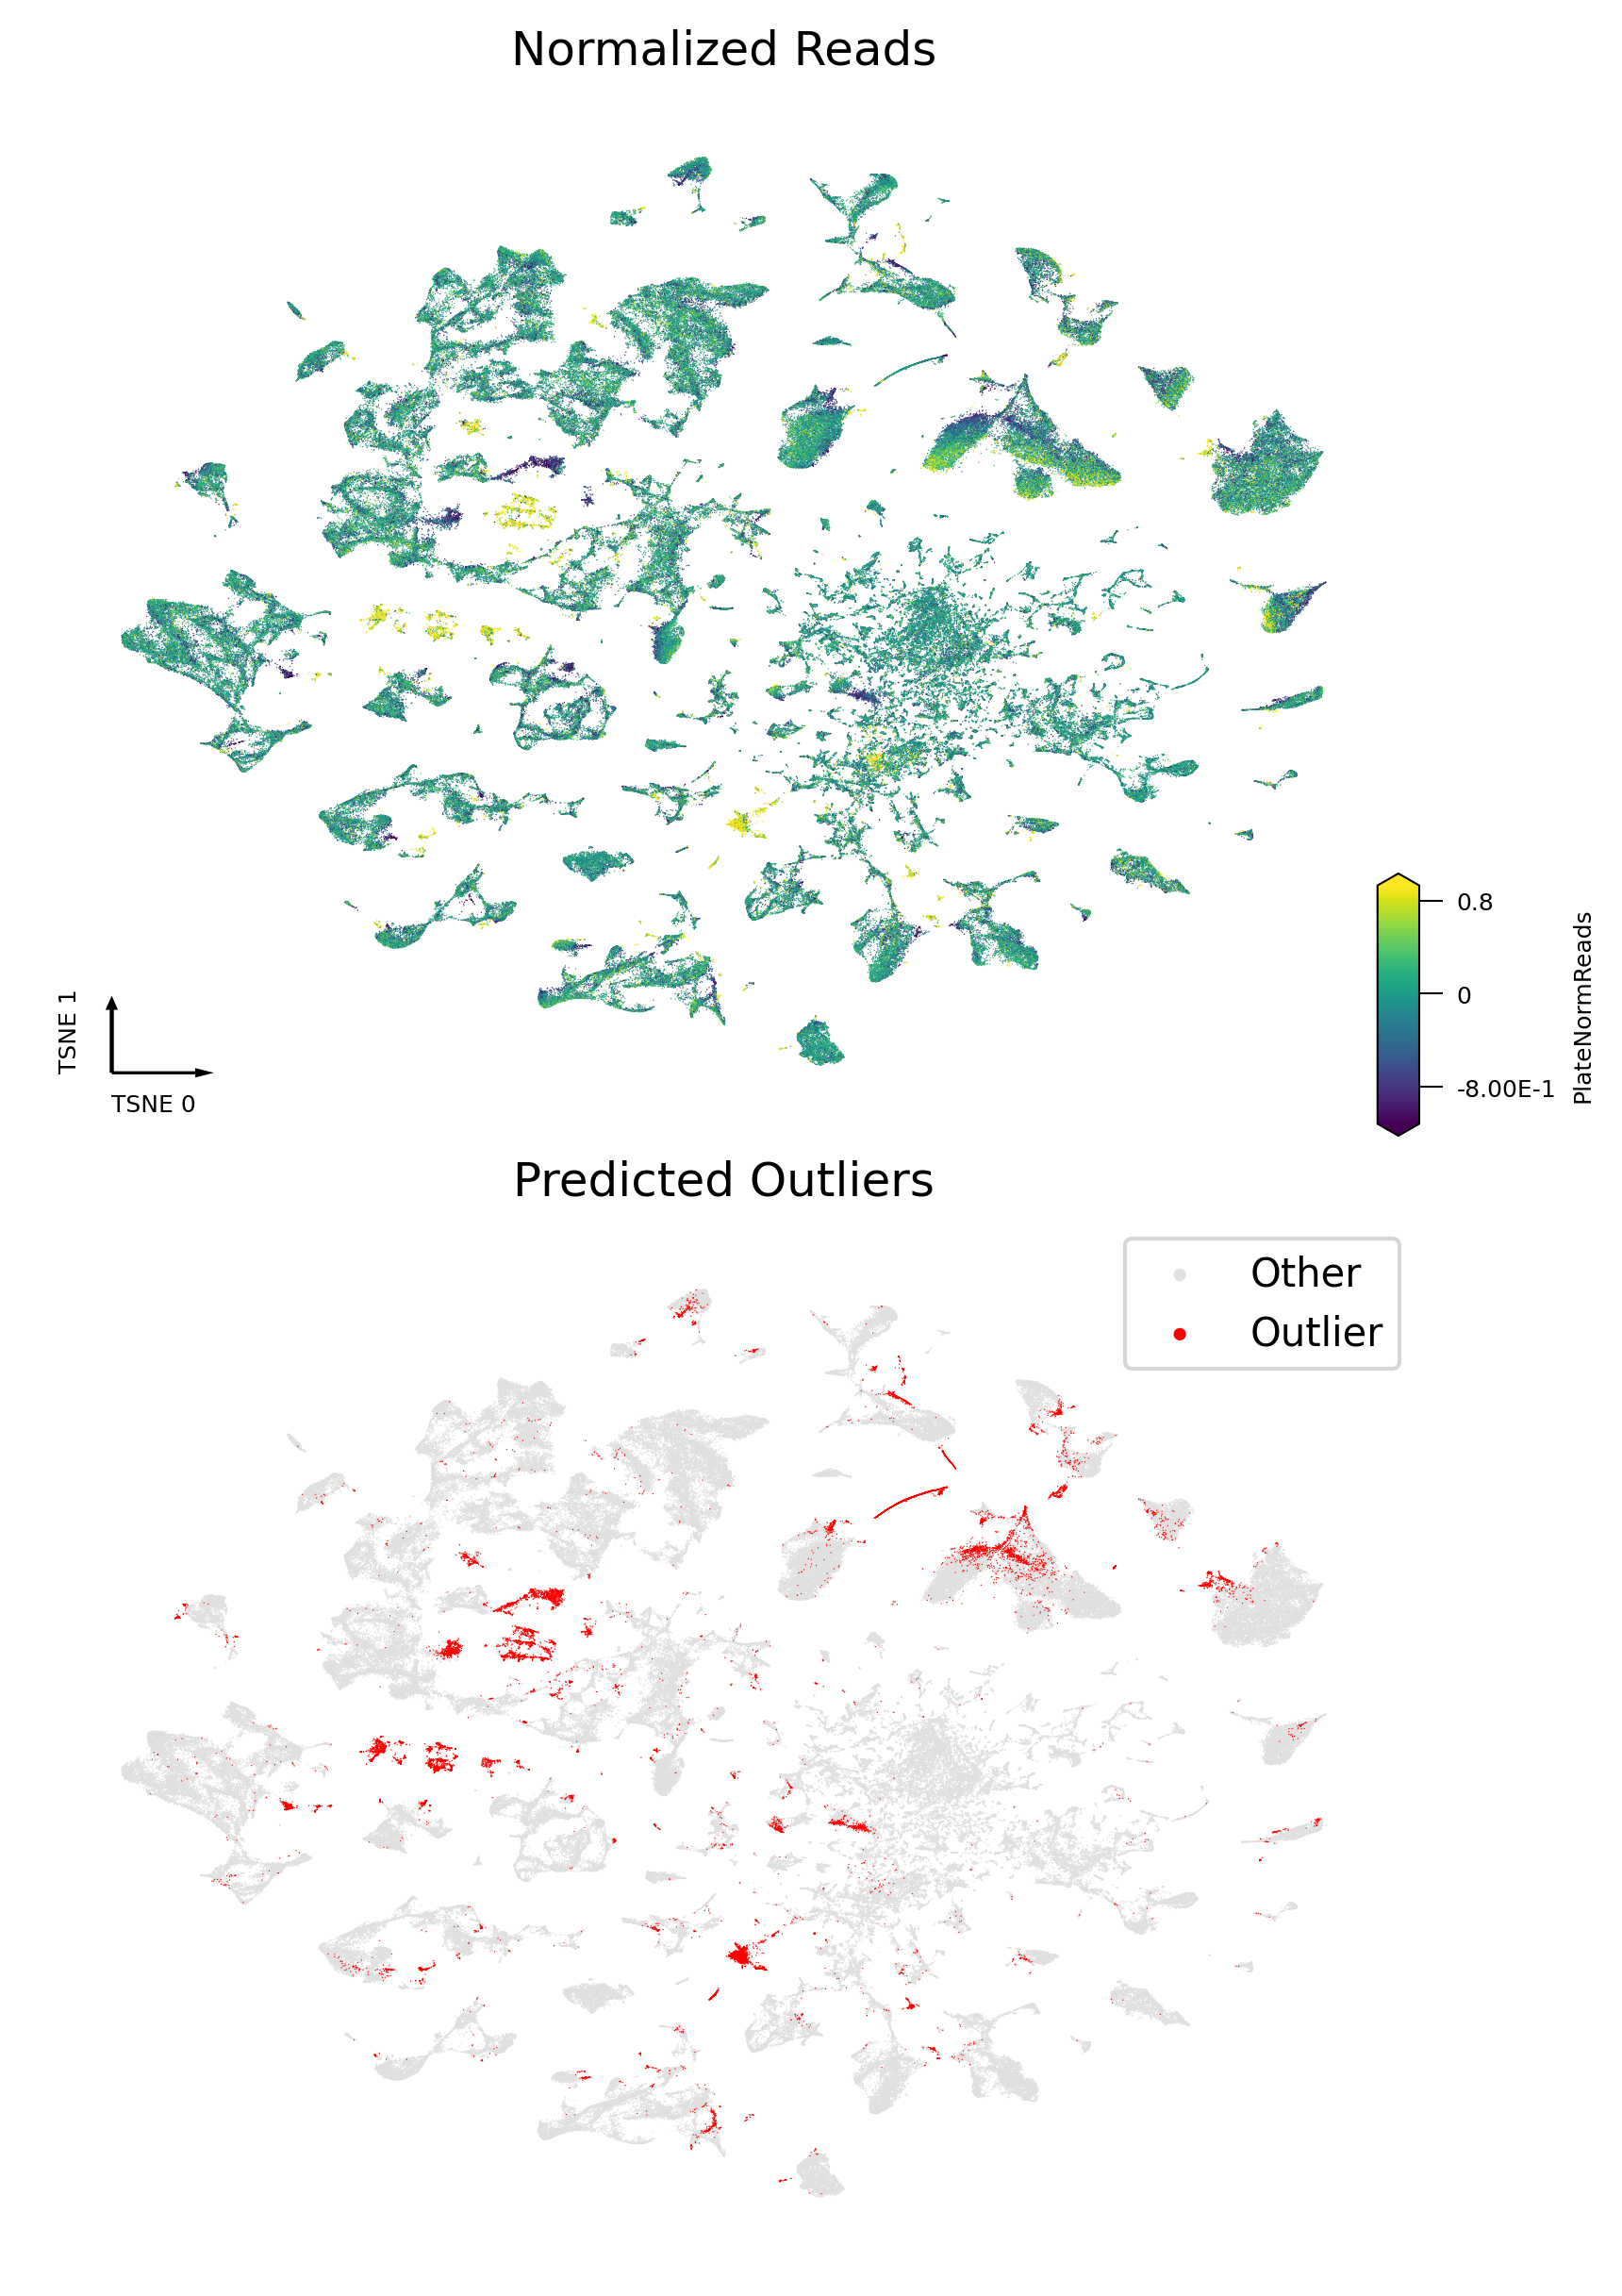

In [75]:
ds = 0.1
fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex='all', sharey='all', dpi=300, constrained_layout=True)
coord_base = 'tsne'
tmp = adata_L1.obs[adata_L1.obs['Study']=='CEMBA_snmC']
ax = axes[1]
ax.axis('off')
selc = (adata_L1.obs['L2']=='outlier')
ax.scatter(adata_L1.obs.loc[~selc, f'{coord_base}_0'], adata_L1.obs.loc[~selc, f'{coord_base}_1'], 
           c='#e0e0e0', s=ds, edgecolor='none', rasterized=True, label='Other')
ax.scatter(adata_L1.obs.loc[selc, f'{coord_base}_0'], adata_L1.obs.loc[selc, f'{coord_base}_1'], 
           c='r', s=ds, edgecolor='none', rasterized=True, label='Outlier')
ax.legend(bbox_to_anchor=(1,1), markerscale=10, loc="upper right")

ax = axes[0]
_ = continuous_scatter(data=adata_L1.obs, 
                       ax=ax, 
                       coord_base=coord_base,
                       s=ds,
                       #cmap='bwr',
                       #hue_norm=[-1.2, 1.2],
                       labelsize=6,
                       max_points=None,
                       scatter_kws={'rasterized':True},
                       hue='PlateNormReads')

for i,xx in enumerate(['Normalized Reads', 'Predicted Outliers']):
    axes.flatten()[i].set_title(xx, fontsize=12)

plt.savefig(f'/gale/netapp/entex/CEMBA_RS2/merged/plot/cell_{adata_L1.shape[0]}_doublet.pdf', transparent=True)


In [58]:
adata.obs.loc[adata.obs['Study']=='CEMBA_EpiRetro', 'Exp'].unique().shape

(703,)

In [59]:
adata.obs['Study'].value_counts()



CEMBA_snmC        301626
CEMBA_EpiRetro     48032
Name: Study, dtype: int64

## Rerun clustering after removing outliers

In [39]:
npc_ch, npc_cg = 66, 64
tmp1 = adata.obsm['100kCH_pca'][:, :npc_ch]
tmp1 = tmp1 / np.std(tmp1)
tmp2 = adata.obsm['100kCG_pca'][:, :npc_cg]
tmp2 = tmp2 / np.std(tmp2)
adata.obsm['X_pca'] = np.concatenate([tmp1, tmp2], axis=1)



In [40]:
tsne(adata, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=50, n_jobs=-1)
dump_embedding(adata, 'tsne')
adata.obsm[f'100kCH100kCG_pc{npc_ch}pc{npc_cg}_tsne'] = adata.obsm['X_tsne'].copy()


In [47]:
selc = (adata.obs['Study']=='CEMBA_EpiRetro')
adata.obs.loc[selc, 'L1_annot'] = adata.obs.loc[selc, 'L1'].map(rs1_annot['L1_cat_annot'].to_pandas())


In [50]:
adata.write_h5ad(f'/gale/netapp/entex/CEMBA_RS2/merged/cell_{adata.shape[0]}_RS1RS2nooutlier_mCHmCG.h5ad')


In [76]:
adata.shape

(349658, 1)

In [77]:
adata = anndata.read_h5ad('/gale/netapp/entex/CEMBA_RS2/merged/cell_349658_RS1RS2nooutlier_mCHmCG.h5ad')
adata


AnnData object with n_obs × n_vars = 349658 × 1
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'Study', 'mCCCmC', 'mCCCCov', 'mCHmC', 'mCHCov', 'mCGmC', 'mCGCov', 'Exp', 'Source', 'Target', 'Gender', 'Quarter', 'tsne_0', 'tsne_1', 'PlateNormReads', 'L1_annot', 'L1', 'L2'
    obsm: '100kCG_pca', '100kCH100kCG_pc150pc150_tsne', '100kCH100kCG_pc66pc64_tsne', '100kCH_pca', 'X_pca', 'X_tsne'

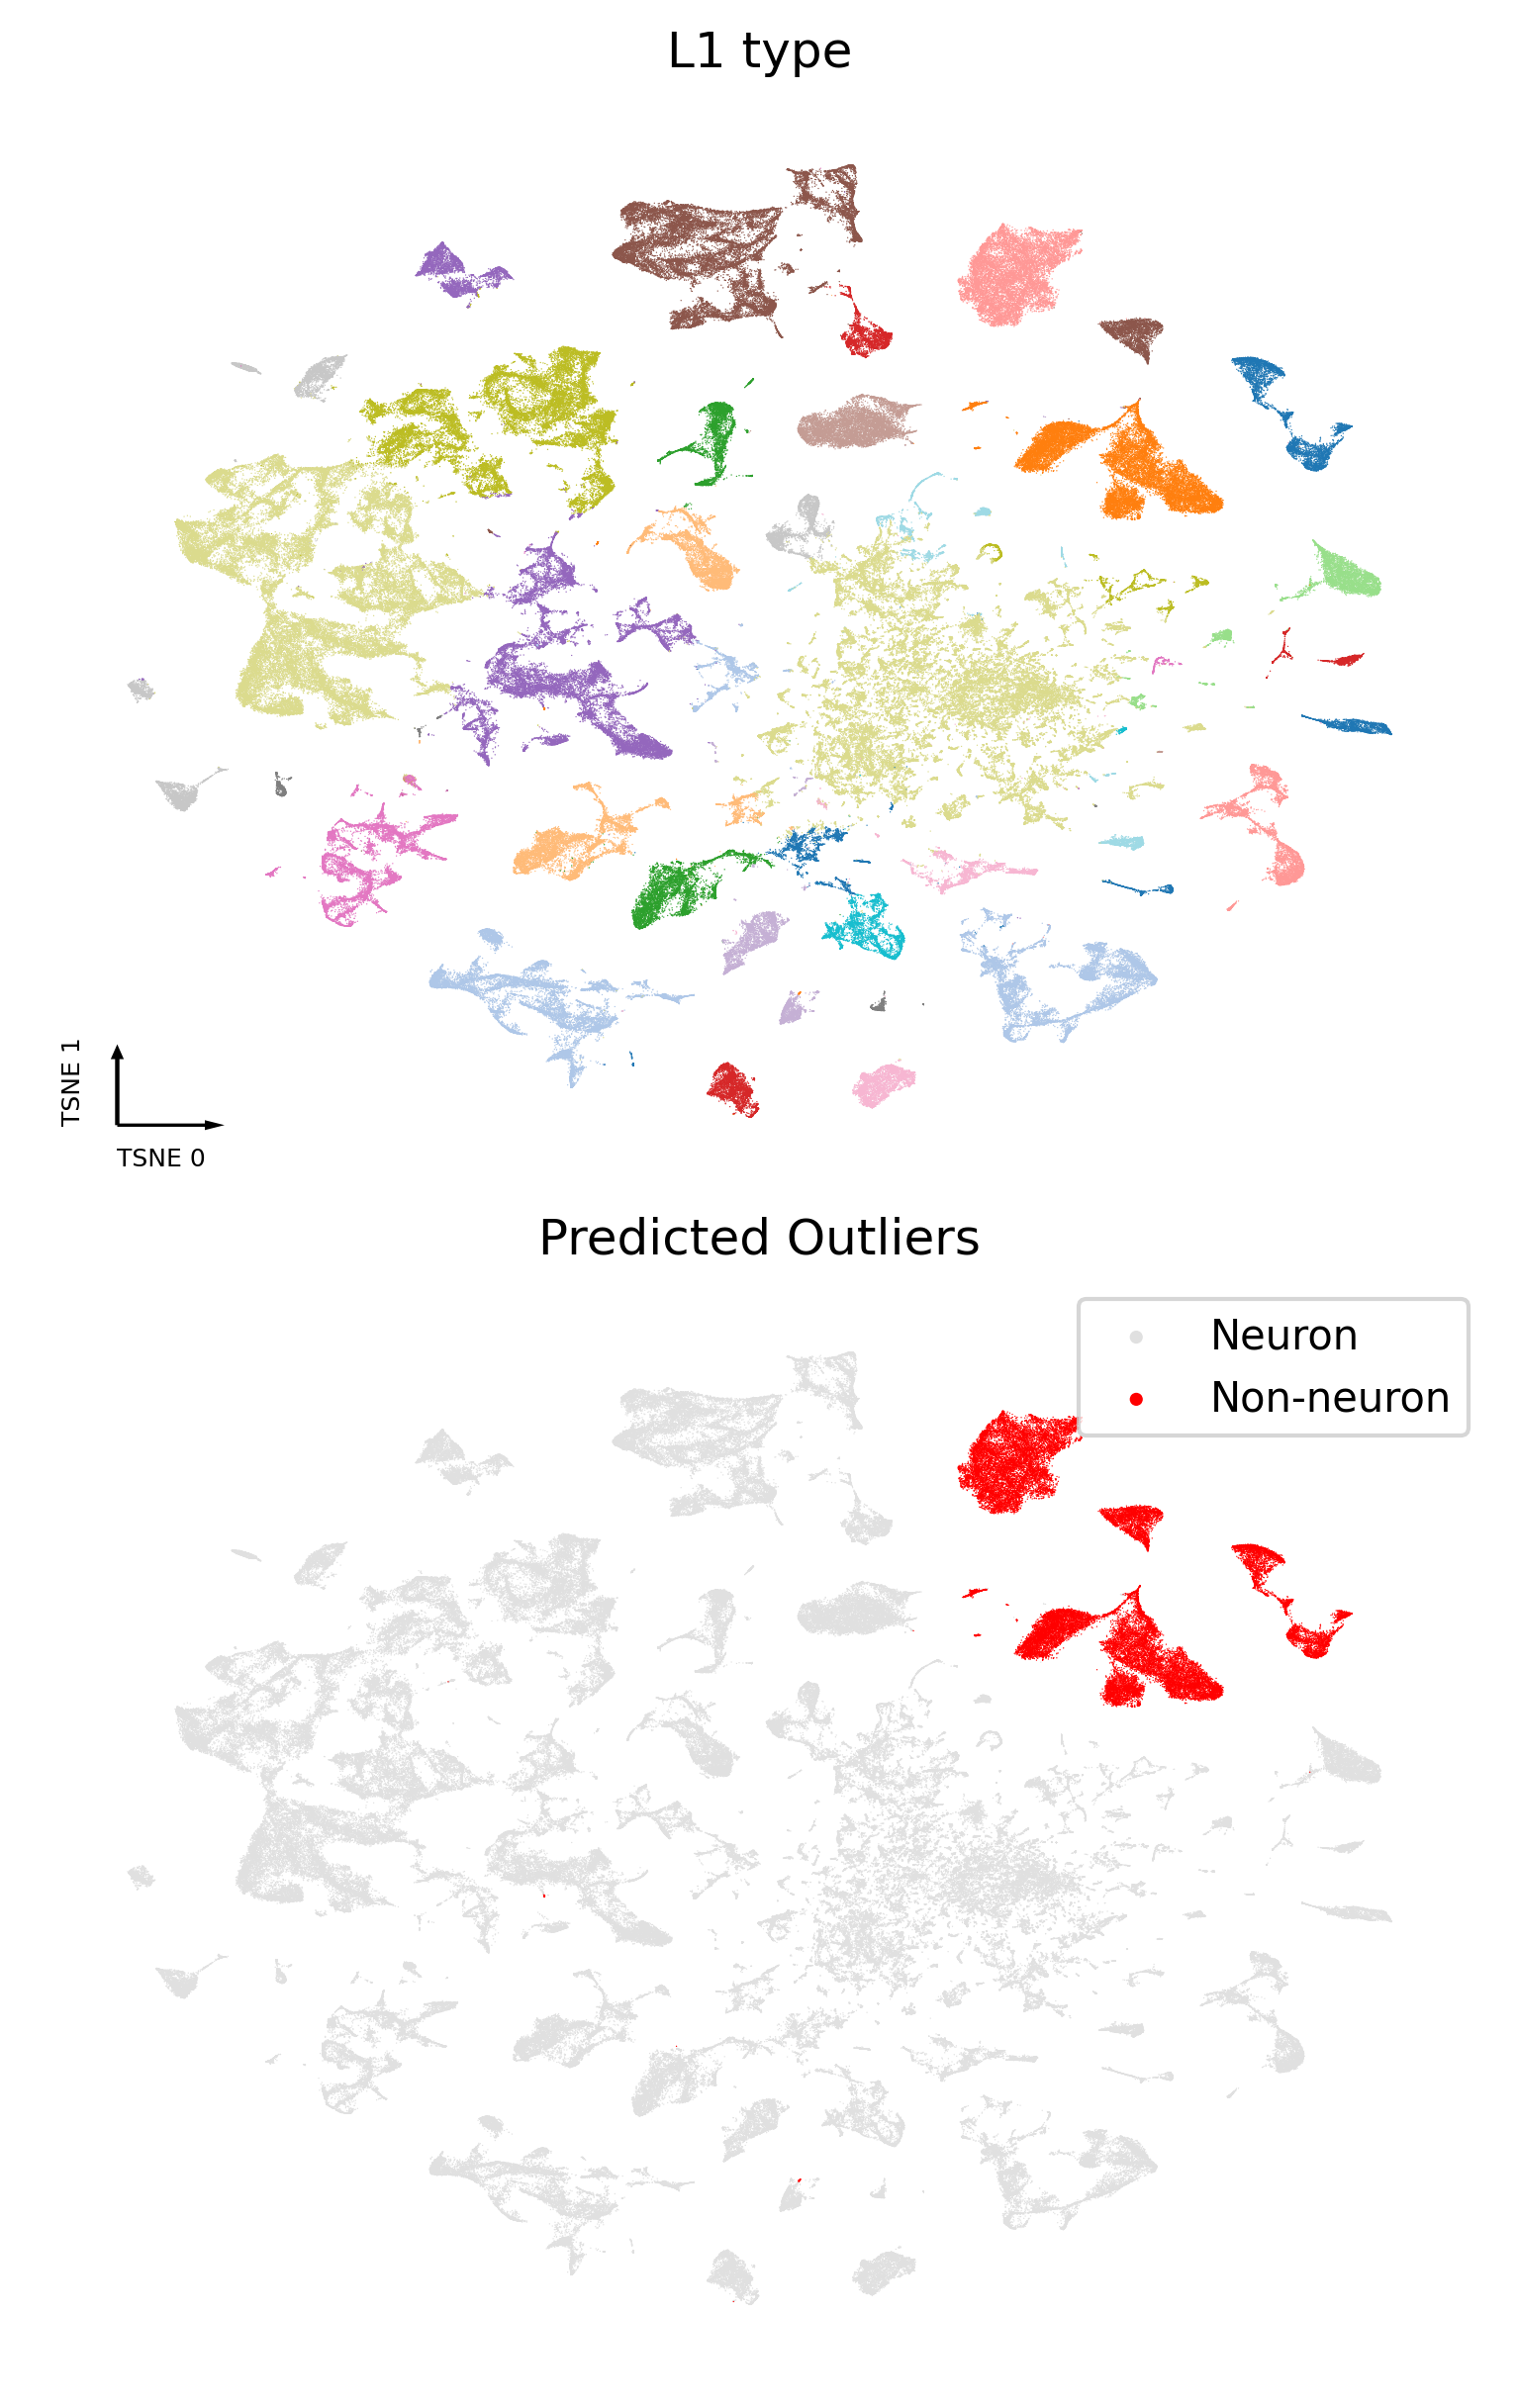

In [81]:
ds = 0.1
fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex='all', sharey='all', dpi=300, constrained_layout=True)
coord_base = 'tsne'
tmp = adata.obs[adata.obs['Study']=='CEMBA_snmC']
ax = axes[1]
ax.axis('off')
selc = adata.obs['L1_annot'].isin(['ASC','ODC','OPC','MGC'])
ax.scatter(adata.obs.loc[~selc, f'{coord_base}_0'], adata.obs.loc[~selc, f'{coord_base}_1'], 
           c='#e0e0e0', s=ds, edgecolor='none', rasterized=True, label='Neuron')
ax.scatter(adata.obs.loc[selc, f'{coord_base}_0'], adata.obs.loc[selc, f'{coord_base}_1'], 
           c='r', s=ds, edgecolor='none', rasterized=True, label='Non-neuron')
ax.legend(bbox_to_anchor=(1,1), markerscale=10, loc="upper right")

ax = axes[0]
L1dict = {xx:yy for yy,xx in zip(cycle(sns.color_palette('tab20')), np.sort(adata.obs['L1_annot'].unique()))}
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base=coord_base,
                        hue='L1_annot',
                        # text_anno='L1_annot',
                        s=ds,
                        palette=L1dict,
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        show_legend=False)

for i,xx in enumerate(['L1 type', 'Predicted NonNeuron']):
    axes.flatten()[i].set_title(xx, fontsize=12)

plt.savefig(f'/gale/netapp/entex/CEMBA_RS2/merged/plot/cell_{adata.shape[0]}_nonneuron.pdf', transparent=True)



In [22]:
meta = pd.read_csv('/gale/netapp/home2/yuwu/projects/RS2/data/rs1rs2metadata_all_294399.csv', header=0, index_col=0)
meta


/gale/netapp/home/zhoujt/miniconda3/envs/scarches/lib/python3.7/site-packages/ipython-7.28.0-py3.7.egg/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


L1     L1_annot            L4 DissectionRegion  \
cell                                                                       
2E_M_2632                 c1       IT-Sup   c1_c1_c3_c0              AON   
1C_M_1701                 c1       IT-Sup   c1_c0_c1_c2              MOB   
1C_M_181                  c1       IT-Sup   c1_c0_c1_c2              MOB   
1C_M_2178                 c1       IT-Sup   c1_c0_c1_c1              MOB   
1C_M_254                  c1       IT-Sup   c1_c0_c1_c1              MOB   
...                      ...          ...           ...              ...   
Pool179_Plate3-6-O5-O23   c0  Subcortical   c0_c3_c8_c2              NaN   
Pool179_Plate3-6-O5-P11   c0  Subcortical   c0_c0_c6_c2              NaN   
Pool179_Plate3-6-O5-P12   c0  Subcortical   c0_c0_c0_c2              NaN   
Pool179_Plate3-6-O5-P23  c57           MY  c57_c0_c0_c0              NaN   
Pool179_Plate3-6-O5-P24   c0  Subcortical   c0_c0_c1_c6              NaN   

                         leiden    umap_0    umap_1  count  umi_count      L2  \
cell                                                                            
2E_M_2632                  12.0  7.772997  1.986519    NaN        NaN   c1_c1   
1C_M_1701                   7.0  8.941594  3.336429    NaN        NaN   c1_c0   
1C_M_181                    7.0  8.914428  3.293081    NaN        NaN   c1_c0   
1C_M_2178                   7.0  9.433117  3.386857    NaN        NaN   c1_c0   
1C_M_254                    7.0  9.285882  3.398305    NaN        NaN   c1_c0   
...                         ...       ...       ...    ...        ...     ...   
Pool179_Plate3-6-O5-O23     NaN       NaN       NaN    NaN        NaN   c0_c3   
Pool179_Plate3-6-O5-P11     NaN       NaN       NaN    NaN        NaN   c0_c0   
Pool179_Plate3-6-O5-P12     NaN       NaN       NaN    NaN        NaN   c0_c0   
Pool179_Plate3-6-O5-P23     NaN       NaN       NaN    NaN        NaN  c57_c0   
Pool179_Plate3-6-O5-P24     NaN       NaN       NaN    NaN        NaN   c0_c0   

                         ...  SubRegion          L4_annot L1_annot_AIBS  \
cell                     ...                                              
2E_M_2632                ...     AON,TT  L4/5 IT CTX Glut         IT-ET   
1C_M_1701                ...    MOB,AON  L2/3 IT CTX Glut         IT-ET   
1C_M_181                 ...    MOB,AON  L2/3 IT CTX Glut         IT-ET   
1C_M_2178                ...    MOB,AON  L2/3 IT CTX Glut         IT-ET   
1C_M_254                 ...    MOB,AON  L2/3 IT CTX Glut         IT-ET   
...                      ...        ...               ...           ...   
Pool179_Plate3-6-O5-O23  ...        NaN               NaN       HB Glut   
Pool179_Plate3-6-O5-P11  ...        NaN               NaN  MB/PONS Gaba   
Pool179_Plate3-6-O5-P12  ...        NaN               NaN       HB Glut   
Pool179_Plate3-6-O5-P23  ...        NaN               NaN       HB Glut   
Pool179_Plate3-6-O5-P24  ...        NaN               NaN       MY Gaba   

                         L1_annot_LHQ         L4_annot_AIBS      L4_annot_LHQ  \
cell                                                                            
2E_M_2632                       IT-ET      L4/5 IT CTX Glut  L4/5 IT CTX Glut   
1C_M_1701                       IT-ET      L2/3 IT CTX Glut  L2/3 IT CTX Glut   
1C_M_181                        IT-ET      L2/3 IT CTX Glut  L2/3 IT CTX Glut   
1C_M_2178                       IT-ET      L2/3 IT CTX Glut  L2/3 IT CTX Glut   
1C_M_254                        IT-ET      L2/3 IT CTX Glut  L2/3 IT CTX Glut   
...                               ...                   ...               ...   
Pool179_Plate3-6-O5-O23       HB Glut  MY Slc6a2 C1ql2 Glut      MY Gpx2 Glut   
Pool179_Plate3-6-O5-P11       HY Glut        HB Phox2b Glut     HY Otp_6 Glut   
Pool179_Plate3-6-O5-P12  MB/PONS Glut         HB Mecom Glut      HB Evx2 Glut   
Pool179_Plate3-6-O5-P23           NaN         HB Foxd3 Glut               NaN   
Pool179_Plate3-6-O5-P24  MB/PONS Gl

In [23]:
adata_neu.obs.loc[meta.index, 'IntegrationRegion'] = meta['IntegrationRegion'].values


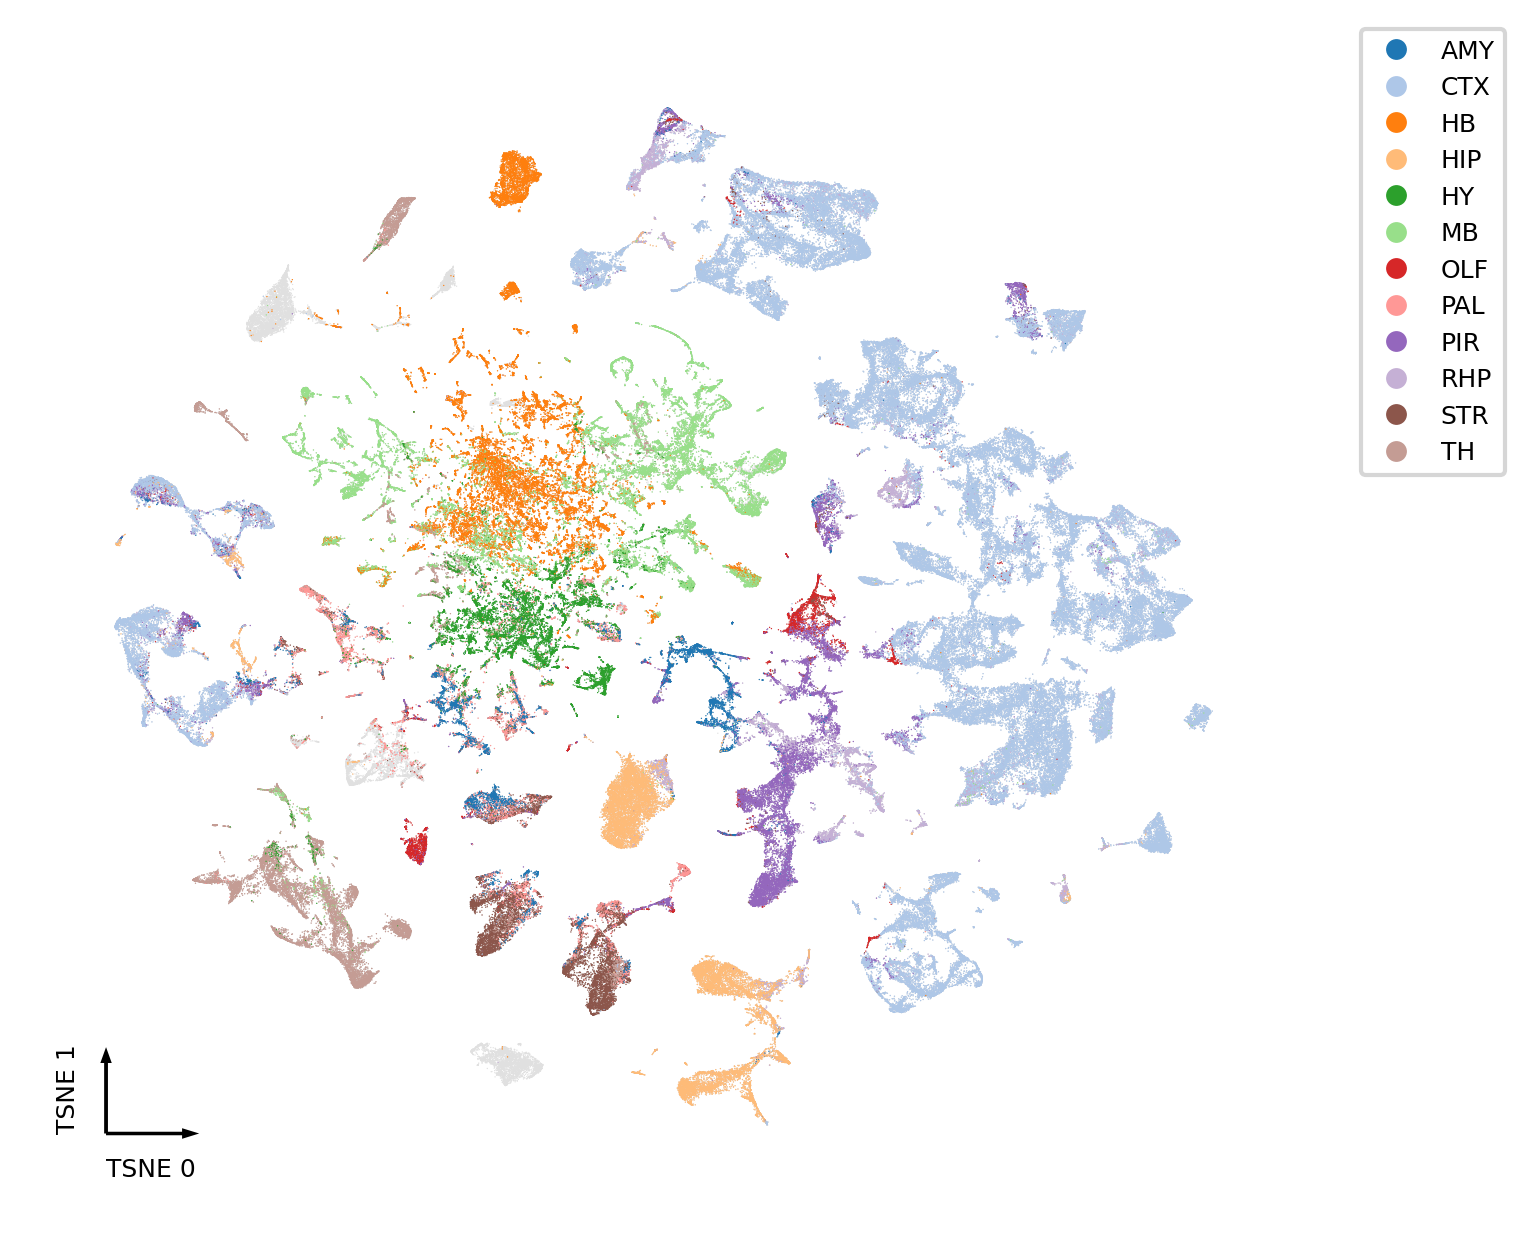

In [26]:
# L1dict = {xx:yy for yy,xx in zip(cycle(sns.color_palette('tab20')), adata_neu.obs['L1_annot'].value_counts().index)}

ds = 0.1
fig, ax = plt.subplots(figsize=(5, 4), dpi=300, constrained_layout=True)
cord_base = 'tsne'
# adata.obsm['X_tsne'] = adata.obsm[f'100kCH100kCG_pc{npc_ch}pc{npc_cg}_tsne'].copy()
# dump_embedding(adata, 'tsne')

# tmp = adata_neu.obs[adata_neu.obs['Study']=='CEMBA_snmC']
ax.scatter(adata_neu.obs[f'{cord_base}_0'], adata_neu.obs[f'{cord_base}_1'], c='#e0e0e0', s=ds, edgecolor='none', rasterized=True)
_ = categorical_scatter(data=adata_neu.obs,
                        ax=ax,
                        coord_base=cord_base,
                        hue='IntegrationRegion',
                        # text_anno='IntegrationRegion',
                        s=ds,
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        show_legend=True
                       )

